# LSTM Model

## Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer 
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers
from keras.preprocessing import sequence
from keras import metrics
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, SimpleRNN, Dropout, LSTM, Bidirectional, Conv1D, concatenate, Lambda
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from scipy.sparse import vstack, hstack
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split

from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive/BT4222/Final/Datasets
md = pd.read_csv('masterdata.csv')

md.head()

/content/drive/.shortcut-targets-by-id/1Py8SHArb42DkhYE5xCHzXMHCuGaduoNn/BT4222/Final/Datasets


,category,rating,label,text_,review_length,end_with_punc,clean_text,target,cleaned_text,category_Books_5,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5,lang
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",12,0,love well made sturdy comfortable love itvery ...,1,love well made sturdy comfortable love itvery ...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",16,0,love great upgrade original ive mine couple years,1,love great upgrade original ive mine couple year,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,14,1,pillow saved back love look feel pillow,1,pillow saved back love look feel pillow,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",17,0,missing information use great product price,1,missing information use great product price,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,18,0,nice set good quality set two months,1,nice set good quality set two month,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en


In [ ]:
md = md.drop(columns=['category', 'label', 'text_', 'lang', 'cleaned_text']) # drop cleaned_text since unlemmatised performed better
md.head()

,rating,review_length,end_with_punc,clean_text,target
0,5.0,12,0,love well made sturdy comfortable love itvery ...,1
1,5.0,16,0,love great upgrade original ive mine couple years,1
2,5.0,14,1,pillow saved back love look feel pillow,1
3,1.0,17,0,missing information use great product price,1
4,5.0,18,0,nice set good quality set two months,1


In [ ]:
# Split train test sets
X = md.drop(columns=['target'], axis = 1)
y = pd.DataFrame(md.loc[:,'target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2) #20% test

In [ ]:
X_train.head()

,rating,review_length,end_with_punc,clean_text,category_Books_5,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5
34158,5.0,28,1,this horse is amazing he looks perfect in my c...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10009,2.0,44,0,poor installation did not apply well lots of b...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37629,1.0,21,1,these shorts ride down for some unknown reason...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15731,4.0,11,1,pretty nice shower head definitely makes low p...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21951,4.0,45,0,i really like the looks of this and the materi...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
y_train.head()

,target
34158,0
10009,0
37629,0
15731,0
21951,1


## Testing different embedding

### Tokenize

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_token = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_token = tokenizer.texts_to_sequences(X_test['clean_text'])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
# Drop the original clean_text column to create X_num (only numerical data)
X_train_num = X_train.drop(columns=['clean_text']) # drop the original clean_text textual data
X_test_num = X_test.drop(columns=['clean_text'])

In [ ]:
maxlen = 100

X_train_padded = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_token, padding='post', maxlen=maxlen)

In [ ]:
X_train_padded

array([[   8, 3317,    7, ...,    0,    0,    0],
       [ 836, 1470,  107, ...,    0,    0,    0],
       [  42, 1521,  977, ...,    0,    0,    0],
       ...,
       [1044,    2,   16, ...,  230,    3,  316],
       [ 328, 1273,   92, ...,    0,    0,    0],
       [ 212,  221,   11, ...,    0,    0,    0]], dtype=int32)

### Word embedding

In [ ]:
embedding_dim = 50

text_input = Input(shape = (maxlen,))
numerical_input = Input(shape = X_train_num.shape[1:])
emb = (Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=100, #maxlen set above is 100
                        trainable=True))(text_input)

text_output = LSTM(units=128)(emb) 
concat = concatenate([text_output, numerical_input]) 

classifier = Dense(128, activation='relu')(concat) 
hidden = Dense(64, activation='relu')(classifier) 
output = Dense(1, activation='sigmoid')(hidden) #output layer sigmoid as binary

simple_LSTMmodel = Model(inputs=[text_input , numerical_input], outputs = output)

simple_LSTMmodel.compile(loss=BinaryCrossentropy(), optimizer = Adam(learning_rate=0.001), metrics=['accuracy',metrics.Precision(), metrics.Recall(),metrics.AUC()])
simple_LSTMmodel.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10) #monitor val loss to prevent overfitting
history_LSTM = simple_LSTMmodel.fit([X_train_padded, X_train_num.to_numpy()],
                                    y_train, 
                                    batch_size=32, 
                                    epochs=10, 
                                    callbacks=[callback],
                                    validation_split=0.2,
                                    verbose=2)


Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_39 (Embedding)       (None, 100, 50)      1879500     ['input_42[0][0]']               
                                                                                                  
 lstm_38 (LSTM)                 (None, 128)          91648       ['embedding_39[0][0]']           
                                                                                                  
 input_43 (InputLayer)          [(None, 13)]         0           []                               
                                                                                           

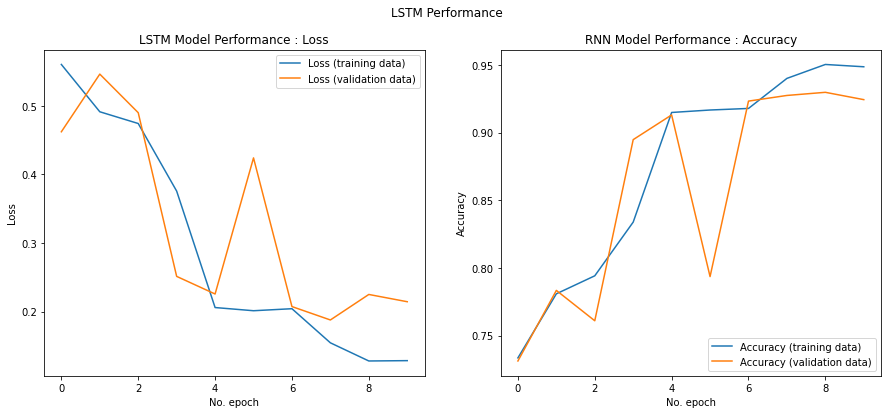

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('LSTM Performance ')

ax1.plot(history_LSTM.history['loss'], label='Loss (training data)')
ax1.plot(history_LSTM.history['val_loss'], label='Loss (validation data)')
ax1.set_title('LSTM Model Performance : Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history_LSTM.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history_LSTM.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('RNN Model Performance : Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
#evaluate training accuracies
scores = simple_LSTMmodel.evaluate([X_train_padded,X_train_num], y_train, verbose=False)
acc = scores[1]
precision = scores[2]
recall = scores[3]
auc = scores[4]
print("Training Accuracy: %.2f%%\n" % (acc*100))
print("Precision: %.2f%%\n" % (precision*100))
print("Recall: %.2f%%\n" % (recall*100))
f1 = 2*(precision * recall)/(precision + recall)
print("F1 Score: %.2f%%\n" % (f1*100))
print("Area Under Curve: %.2f%%\n" % (auc*100))

Training Accuracy: 95.35%

Precision: 98.46%

Recall: 92.14%

F1 Score: 95.20%

Area Under Curve: 99.15%



In [ ]:
#evaluate testing accuracies
scores = simple_LSTMmodel.evaluate([X_test_padded,X_test_num], y_test, verbose=False)
acc = scores[1]
precision = scores[2]
recall = scores[3]
auc = scores[4]
print("Testing Accuracy: %.2f%%\n" % (acc*100))
print("Precision: %.2f%%\n" % (precision*100))
print("Recall: %.2f%%\n" % (recall*100))
f1 = 2*(precision * recall)/(precision + recall)
print("F1 Score: %.2f%%\n" % (f1*100))
print("Area Under Curve: %.2f%%\n" % (auc*100))

Testing Accuracy: 92.26%

Precision: 96.39%

Recall: 87.82%

F1 Score: 91.91%

Area Under Curve: 97.89%



### GloVe

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    "glove.6B.50d.txt",
    tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.814726018274328

In [ ]:
text_input = Input(shape = (maxlen,))
numerical_input = Input(shape = X_train_num.shape[1:])
emb = (Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix],
                        input_length=100, #maxlen set above is 100
                        trainable=True))(text_input)

text_output = LSTM(units=128)(emb) 
concat = concatenate([text_output, numerical_input]) 

classifier = Dense(128, activation='relu')(concat) 
hidden = Dense(64, activation='relu')(classifier) 
output = Dense(1, activation='sigmoid')(hidden) #output layer sigmoid as binary

simple_LSTMmodel_glove = Model(inputs=[text_input , numerical_input], outputs = output)

simple_LSTMmodel_glove.compile(loss=BinaryCrossentropy(), optimizer = Adam(learning_rate=0.001), metrics=['accuracy',metrics.Precision(), metrics.Recall(),metrics.AUC()])
simple_LSTMmodel_glove.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10) #monitor val loss to prevent overfitting
history_LSTM_glove = simple_LSTMmodel_glove.fit([X_train_padded, X_train_num.to_numpy()],
                                                y_train, 
                                                batch_size=32, 
                                                epochs=10, 
                                                callbacks=[callback],
                                                validation_split=0.2,
                                                verbose=2)


Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_37 (Embedding)       (None, 100, 50)      1879500     ['input_38[0][0]']               
                                                                                                  
 lstm_36 (LSTM)                 (None, 128)          91648       ['embedding_37[0][0]']           
                                                                                                  
 input_39 (InputLayer)          [(None, 13)]         0           []                               
                                                                                           

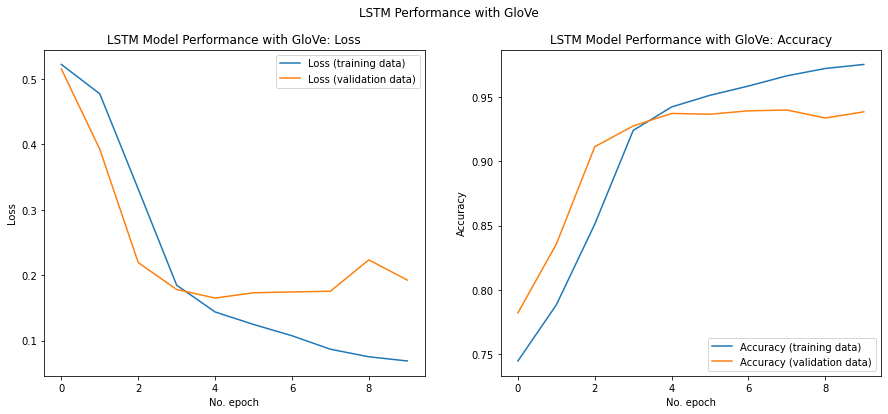

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('LSTM Performance with GloVe')

ax1.plot(history_LSTM_glove.history['loss'], label='Loss (training data)')
ax1.plot(history_LSTM_glove.history['val_loss'], label='Loss (validation data)')
ax1.set_title('LSTM Model Performance with GloVe: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history_LSTM_glove.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history_LSTM_glove.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('LSTM Model Performance with GloVe: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
#evaluate training accuracies
scores = simple_LSTMmodel_glove.evaluate([X_train_padded,X_train_num], y_train, verbose=False)
acc = scores[1]
precision = scores[2]
recall = scores[3]
auc = scores[4]
print("Training Accuracy: %.2f%%\n" % (acc*100))
print("Precision: %.2f%%\n" % (precision*100))
print("Recall: %.2f%%\n" % (recall*100))
f1 = 2*(precision * recall)/(precision + recall)
print("F1 Score: %.2f%%\n" % (f1*100))
print("Area Under Curve: %.2f%%\n" % (auc*100))

Training Accuracy: 97.38%

Precision: 98.45%

Recall: 96.28%

F1 Score: 97.35%

Area Under Curve: 99.52%



In [ ]:
# evaluate testing accuracies
scores = simple_LSTMmodel_glove.evaluate([X_test_padded,X_test_num], y_test, verbose=False)
acc = scores[1]
precision = scores[2]
recall = scores[3]
auc = scores[4]
print("Testing Accuracy: %.2f%%\n" % (acc*100))
print("Precision: %.2f%%\n" % (precision*100))
print("Recall: %.2f%%\n" % (recall*100))
f1 = 2*(precision * recall)/(precision + recall)
print("F1 Score: %.2f%%\n" % (f1*100))
print("Area Under Curve: %.2f%%\n" % (auc*100))

Testing Accuracy: 93.60%

Precision: 95.69%

Recall: 91.31%

F1 Score: 93.45%

Area Under Curve: 98.25%



## Hyperparameter tuning

1. Embedding Dimension [50, 100, 150]
2. Hidden Units [32, 64, 128]
3. Drop-out Rate [0.0, 0.2, 0.4]
4. Learning Rate [0.001, 0.01]
5. Batch Size [32, 64, 128]

In [ ]:
#glove to be used
def create_model(embedding_dim, batch_size, hidden_units, dropout_rate, learning_rate):
  maxlen =100
  if embedding_dim == 50:
      emb_matrix = create_embedding_matrix("glove.6B.50d.txt", tokenizer.word_index, embedding_dim)
  elif embedding_dim == 100:
      emb_matrix = create_embedding_matrix("glove.6B.100d.txt", tokenizer.word_index, embedding_dim)
  else:
      emb_matrix = create_embedding_matrix("glove.6B.200d.txt", tokenizer.word_index, embedding_dim)

  combi_input = Input(shape=(113,)) 
  text_input = Lambda(lambda x: x[:,:maxlen])(combi_input) 
  numerical_input = Lambda(lambda x: x[:,maxlen:],-1)(combi_input) #take aft text 

  emb = (Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            weights=[emb_matrix],
                            input_length=100, 
                            trainable=True))(text_input)

  text_output = LSTM(units=hidden_units)(emb) # feed text_input to LSTM layer first
  concat = concatenate([text_output, numerical_input]) 
  
  dropout1 = Dropout(dropout_rate)(concat)
  dense1 = Dense(hidden_units, activation='relu')(dropout1)
  dropout2 = Dropout(dropout_rate)(dense1)
  dense2 = Dense(hidden_units/2, activation='relu')(dropout2)                     
  dropout3 = Dropout(dropout_rate)(dense2)     
  output = Dense(1, activation='sigmoid')(dropout3)

  LSTMmodel_glove_tuned = Model(inputs=[combi_input], outputs=output)

  LSTMmodel_glove_tuned.compile(loss=BinaryCrossentropy(), 
                                optimizer = Adam(learning_rate=learning_rate), 
                                metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
  LSTMmodel_glove_tuned.summary()

  #callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10) #monitor val loss to prevent overfitting
  return LSTMmodel_glove_tuned

In [ ]:
param_grid = dict(embedding_dim=[50, 100, 150],
                  hidden_units=[32, 64, 128],
                  dropout_rate=[0.2, 0.3, 0.4],
                  learning_rate=[0.001,0.01],
                  batch_size=[32,64,128])

In [ ]:
#creates model callback to stop model if val loss does not decrease for more than 5 consecutive epochs
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=2, 
                   patience=10)

#creates model callback to save model with the lowest val loss
mc = ModelCheckpoint('best_LSTM.hdf5', 
                     monitor='val_loss',
                     mode='min',
                     verbose=2, 
                     save_best_only=True)
callbacks = [es, mc]

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=50)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
X_train_concat = np.hstack((X_train_padded, X_train_num.to_numpy().astype('float32')))
X_test_concat = np.hstack((X_test_padded, X_test_num.to_numpy().astype('float32')))

In [ ]:
X_train_concat.shape

(32289, 113)

In [ ]:
grid_result = grid.fit(X_train_concat, y_train,
                        verbose=2,
                        validation_split=0.2,
                        callbacks = es)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 113)]        0           []                               
                                                                                                  
 lambda_68 (Lambda)             (None, 100)          0           ['input_35[0][0]']               
                                                                                                  
 embedding_34 (Embedding)       (None, 100, 50)      1879500     ['lambda_68[0][0]']              
                                                                                                  
 lstm_34 (LSTM)                 (None, 128)          91648       ['embedding_34[0][0]']           
                              

In [ ]:
test_accuracy = grid_result.score(X_test_concat, y_test)

64/64 [==============================] - 1s 16ms/step - loss: 0.2473 - accuracy: 0.9264 - precision_34: 0.9398 - recall_34: 0.9114 - auc_34: 0.9771


In [ ]:
pd.DataFrame(grid_result.cv_results_)

In [ ]:
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_hidden_units,param_embedding_dim,param_dropout_rate,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,434.614299,17.458305,30.361578,20.070218,0.001,64,150,0.3,32,"{'learning_rate': 0.001, 'hidden_units': 64, '...",0.913128,0.921026,0.913221,0.915792,0.003701,2
1,215.898401,17.219925,12.289517,7.216272,0.01,64,100,0.2,64,"{'learning_rate': 0.01, 'hidden_units': 64, 'e...",0.901514,0.892223,0.897519,0.897086,0.003805,5
2,220.420743,30.549364,47.488058,3.097180,0.01,128,150,0.2,64,"{'learning_rate': 0.01, 'hidden_units': 128, '...",0.903280,0.900957,0.898541,0.900926,0.001935,4
3,243.108245,89.877654,16.209556,15.525537,0.01,32,150,0.2,64,"{'learning_rate': 0.01, 'hidden_units': 32, 'e...",0.891016,0.893060,0.887206,0.890427,0.002426,7
4,212.176192,20.748854,18.365943,14.374375,0.001,32,100,0.4,128,"{'learning_rate': 0.001, 'hidden_units': 32, '...",0.917216,0.903651,0.908854,0.909907,0.005588,3
5,234.539848,56.684898,38.574729,11.378133,0.001,128,50,0.3,128,"{'learning_rate': 0.001, 'hidden_units': 128, ...",0.923348,0.920282,0.923906,0.922512,0.001593,1
6,530.038762,93.497403,36.927609,23.951678,0.01,128,150,0.3,32,"{'learning_rate': 0.01, 'hidden_units': 128, '...",0.888321,0.872805,0.894825,0.885317,0.009237,9
7,125.033448,4.569372,38.583510,5.761057,0.01,32,150,0.3,128,"{'learning_rate': 0.01, 'hidden_units': 32, 'e...",0.893710,0.893803,0.896776,0.894763,0.001424,6
8,522.252389,107.688405,29.208767,16.494514,0.01,128,100,0.3,32,"{'learning_rate': 0.01, 'hidden_units': 128, '...",0.884698,0.885348,0.893896,0.887980,0.004191,8
9,423.059035,16.836065,24.427035,21.096581,0.01,32,50,0.4,32,"{'learning_rate': 0.01, 'hidden_units': 32, 'e...",0.887857,0.887206,0.880888,0.885317,0.003143,9


In [ ]:
print('Best Score: %s' % grid_result.best_score_)
print('Best Hyperparameters: %s' % grid_result.best_params_)

Best Score: 0.9225122928619385
Best Hyperparameters: {'learning_rate': 0.001, 'hidden_units': 128, 'embedding_dim': 50, 'dropout_rate': 0.3, 'batch_size': 128}


## Re-run a model with the best hyperparameters on its own

In [ ]:
emb_matrix = create_embedding_matrix("glove.6B.50d.txt", tokenizer.word_index, 50)

combi_input = Input(shape=(113,)) 
text_input = Lambda(lambda x: x[:,:maxlen])(combi_input) 
numerical_input = Lambda(lambda x: x[:,maxlen:],-1)(combi_input) #take aft text 

emb = (Embedding(input_dim=vocab_size, 
                          output_dim=50, 
                          weights=[emb_matrix],
                          input_length=100, 
                          trainable=True))(text_input)

text_output = LSTM(units=128)(emb) # feed text_input to LSTM layer first
concat = concatenate([text_output, numerical_input]) 

dropout1 = Dropout(0.3)(concat)
dense1 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(dropout2)                     
dropout3 = Dropout(0.3)(dense2)     
output = Dense(1, activation='sigmoid')(dropout3)

LSTMmodel_best = Model(inputs=[combi_input], outputs=[output])

LSTMmodel_best.compile(loss=BinaryCrossentropy(), 
                              optimizer = Adam(learning_rate=0.001), 
                              metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
LSTMmodel_best.summary()

es = EarlyStopping(monitor='val_loss', 
               mode='min', 
               patience=10)

mc = ModelCheckpoint('best_LSTM_model.hdf5', 
                 monitor='val_loss',
                 mode='min',
                 verbose=1, 
                 save_best_only=True)
callbacks = [es, mc]

history = LSTMmodel_best.fit(X_train_concat, y_train,
                    epochs=50,
                    verbose=2,
                    validation_split=0.2,
                    batch_size=128,
                 callbacks = callbacks)

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 113)]        0           []                               
                                                                                                  
 lambda_72 (Lambda)             (None, 100)          0           ['input_37[0][0]']               
                                                                                                  
 embedding_36 (Embedding)       (None, 100, 50)      1879500     ['lambda_72[0][0]']              
                                                                                                  
 lstm_35 (LSTM)                 (None, 128)          91648       ['embedding_36[0][0]']           
                                                                                           

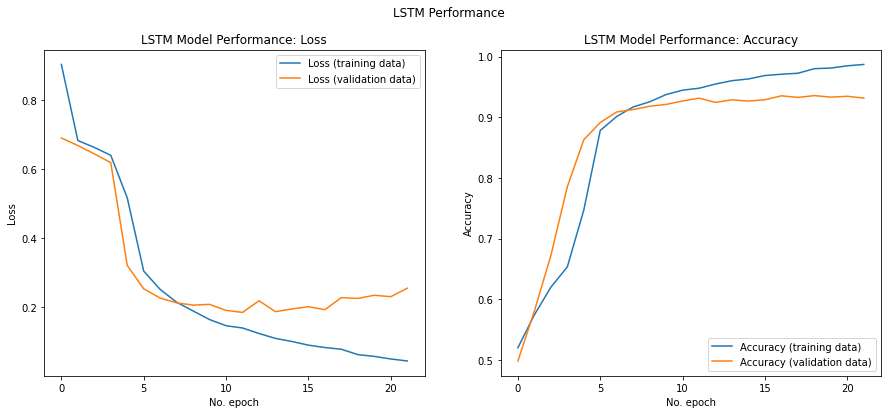

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('LSTM Performance')

ax1.plot(history.history['loss'], label='Loss (training data)')
ax1.plot(history.history['val_loss'], label='Loss (validation data)')
ax1.set_title('LSTM Model Performance: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('LSTM Model Performance: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
model = load_model('best_LSTM_model.hdf5')

loss, accuracy, precision, recall, auc = model.evaluate(X_test_concat, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))
print("Precisiony: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Testing Accuracy:  92.6793%
Precisiony: 93.7357%
Recall: 91.4851%
F1 Score: 92.5968%
Area under Curve: 98.0407%
